# ⚛️ H₂ VQE — Noisy Optimizer Comparison (Production API)

This notebook compares **classical optimizers** for **H₂ VQE** under different
**noise channels**, using only the **packaged VQE API**.

We will run **multi-seed noise statistics** and compare optimizers by:

- Mean and standard deviation of the **energy error**:  ΔE = E_noisy − E_ref
- Mean and standard deviation of the **fidelity** vs a noiseless reference state
- Across a grid of **noise strengths**

The key entry point used here is:

```python
from vqe.core import run_vqe_optimizer_comparison
```

---

## What this notebook does (and does not) do

✅ Uses **only** production package functions (no hand-built QNodes).  
✅ Uses **multi-seed statistics** for robustness.  
✅ Produces **overlay plots**: one curve per optimizer.  

❌ Does not manually implement VQE loops inside the notebook.  
❌ Does not implement new noise models beyond what the package already supports.

## 1️⃣ Imports and configuration

In [1]:
import numpy as np

from vqe.core import run_vqe_optimizer_comparison

### Experiment defaults

- Molecule: **H₂**
- Ansatz: **UCCSD**
- Mapping: **Jordan–Wigner**
- Noise grid: **0.00 → 0.10**
- Seeds: **0 → 9**

The runtime scales approximately with:

$$\text{cost} \sim N_{\text{optimizers}} \times N_{\text{noise}} \times N_{\text{seeds}} \times N_{\text{steps}}$$


In [ ]:
molecule = "H2"
ansatz_name = "UCCSD"
mapping = "jordan_wigner"

# Noise grid in [0.00, 0.10]
noise_levels = np.arange(0.0, 0.11, 0.02)

# Multi-seed statistics
seeds = np.arange(0, 10)

# Optimizers to compare
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "RMSProp", "Adagrad"]

# Optimization parameters
steps = 50
stepsize_map = {
    "Adam": 0.2,
    "GradientDescent": 0.05,
    "Momentum": 0.1,
    "Nesterov": 0.1,
    "RMSProp": 0.1,
    "Adagrad": 0.2,
}

print("Noise levels:", noise_levels)
print("Seeds:", seeds)
print("Steps:", steps)
print("Stepsizes:", stepsize_map)


Noise levels: [0.   0.02 0.04 0.06 0.08 0.1 ]
Seeds: [0]
Steps: 50
Stepsizes: {'Adam': 0.2, 'GradientDescent': 0.05, 'Momentum': 0.1, 'Nesterov': 0.1, 'RMSProp': 0.1, 'Adagrad': 0.2}


## 2️⃣ Helper: simple robustness score

To summarise an optimizer’s robustness into a single number, we compute:

- **AUC(ΔE)** over the noise grid: smaller is better
- **AUC(1 − Fidelity)** over the noise grid: smaller is better

These are coarse summaries, but useful for quick ranking.

In [3]:
def auc_trapz(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return float(np.trapz(y, x))

def summarise_noise_stats(result_dict):
    """
    Build a compact summary table from the output of
    run_vqe_optimizer_comparison(mode="noise_stats", ...).
    """
    x = np.asarray(result_dict["noise_levels"], dtype=float)
    rows = []
    for opt_name, data in result_dict["optimizers"].items():
        deltaE_mean = np.asarray(data["deltaE_mean"], dtype=float)
        fid_mean = np.asarray(data["fidelity_mean"], dtype=float)

        rows.append(
            {
                "optimizer": opt_name,
                "stepsize": float(data.get("stepsize", np.nan)),
                "AUC_deltaE": auc_trapz(x, np.abs(deltaE_mean)),
                "AUC_1_minus_fidelity": auc_trapz(x, 1.0 - fid_mean),
                "deltaE_at_max_noise": float(deltaE_mean[-1]),
                "fidelity_at_max_noise": float(fid_mean[-1]),
            }
        )

    # Sort by energy robustness then fidelity robustness
    rows = sorted(rows, key=lambda r: (r["AUC_deltaE"], r["AUC_1_minus_fidelity"]))
    return rows

def print_summary(rows, title):
    print("\n" + title)
    print("-" * len(title))
    header = f"{'optimizer':<18s} {'stepsize':>9s} {'AUC|ΔE|':>12s} {'AUC(1-F)':>12s} {'ΔE@max':>12s} {'F@max':>10s}"
    print(header)
    print("-" * len(header))
    for r in rows:
        print(
            f"{r['optimizer']:<18s} "
            f"{r['stepsize']:>9.3f} "
            f"{r['AUC_deltaE']:>12.6f} "
            f"{r['AUC_1_minus_fidelity']:>12.6f} "
            f"{r['deltaE_at_max_noise']:>12.6f} "
            f"{r['fidelity_at_max_noise']:>10.4f}"
        )

## 3️⃣ Depolarizing noise: optimizer comparison (multi-seed)

We sweep depolarizing probability `p` and set amplitude damping to zero:

- `noise_type="depolarizing"`
- `noise_levels = [0.00, 0.02, ..., 0.10]`

The package function will:
- compute per-seed noiseless references,
- run noisy VQE across seeds/noise levels for each optimizer,
- compute ΔE and fidelity mean/std,
- optionally generate **overlay plots** (one curve per optimizer).


⚙️ Optimizer: Adam (stepsize=0.2)
  🔹 Computing noiseless references per seed...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__a56aed30983c.json
  🔹 Sweeping noise levels...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__deaa122a3bf1.json
    p_dep=0.00, p_amp=0.00: ΔE=0.000028 ± 0.000000, ⟨F⟩=1.0000 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__48170c0a907f.json
    p_dep=0.02, p_amp=0.00: ΔE=0.036559 ± 0.000000, ⟨F⟩=0.9463 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__c7e06bfcce45.json
    p_dep=0.04, p_amp=0.00: ΔE=0.072353 ± 0.000000, ⟨F⟩=0.8949 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__a8aadc11e491.json
    p_dep=0.06

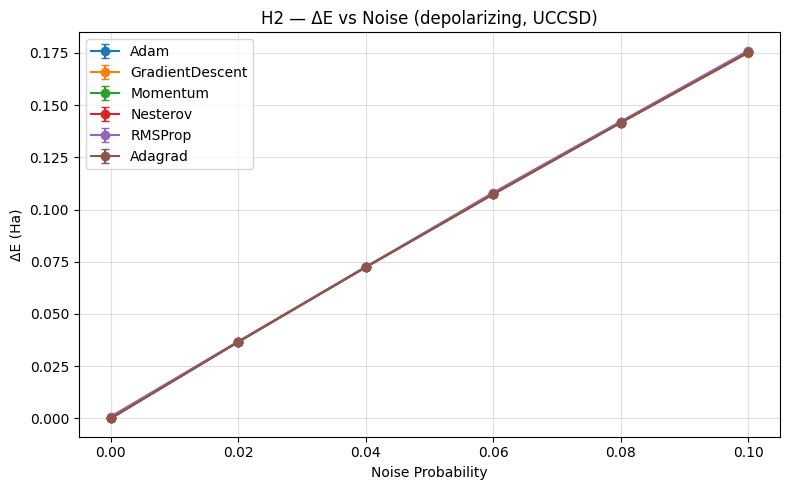

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/noisy_optimizer_comparison_deltae_UCCSD_noise_scan_dep.png


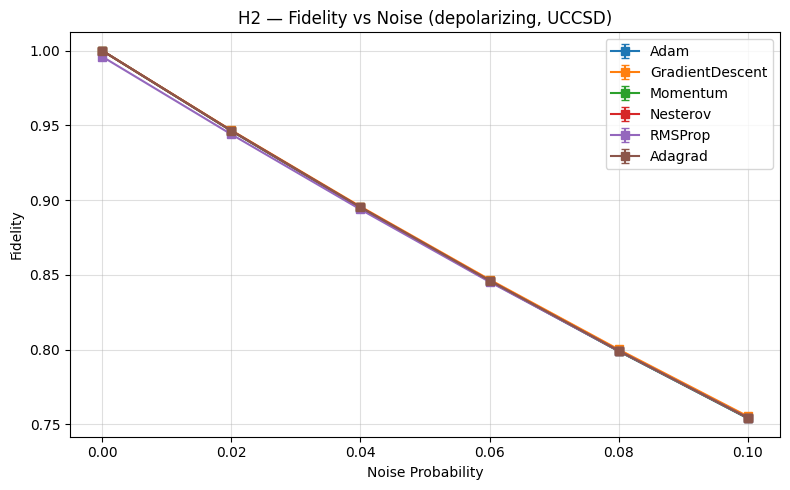

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/noisy_optimizer_comparison_fidelity_UCCSD_noise_scan_dep.png

Depolarizing noise — robustness summary
---------------------------------------
optimizer           stepsize      AUC|ΔE|     AUC(1-F)       ΔE@max      F@max
------------------------------------------------------------------------------
GradientDescent        0.050     0.008908     0.012653     0.175119     0.7554
Adam                   0.200     0.008909     0.012740     0.175204     0.7541
Adagrad                0.200     0.008914     0.012710     0.175240     0.7545
Nesterov               0.100     0.008914     0.012710     0.175241     0.7545
Momentum               0.100     0.008916     0.012724     0.175277     0.7542
RMSProp                0.100     0.008959     0.012846     0.176054     0.7545


In [4]:
dep_results = run_vqe_optimizer_comparison(
    molecule=molecule,
    ansatz_name=ansatz_name,
    optimizers=optimizers,
    steps=steps,
    stepsize=stepsize_map,
    mode="noise_stats",
    noise_type="depolarizing",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

dep_summary = summarise_noise_stats(dep_results)
print_summary(dep_summary, title="Depolarizing noise — robustness summary")


## 4️⃣ Amplitude damping noise: optimizer comparison (multi-seed)

We now sweep amplitude damping probability `p` and set depolarizing to zero:

- `noise_type="amplitude"`

In [5]:
amp_results = run_vqe_optimizer_comparison(
    molecule=molecule,
    ansatz_name=ansatz_name,
    optimizers=optimizers,
    steps=steps,
    stepsize=stepsize_map,
    mode="noise_stats",
    noise_type="amplitude",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

amp_summary = summarise_noise_stats(amp_results)
print_summary(amp_summary, title="Amplitude damping — robustness summary")



⚙️ Optimizer: Adam (stepsize=0.2)
  🔹 Computing noiseless references per seed...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__a56aed30983c.json
  🔹 Sweeping noise levels...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__deaa122a3bf1.json
    p_dep=0.00, p_amp=0.00: ΔE=0.000028 ± 0.000000, ⟨F⟩=1.0000 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__8585f63b925e.json
    p_dep=0.00, p_amp=0.02: ΔE=0.024589 ± 0.000000, ⟨F⟩=0.9604 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__34535eb60c26.json
    p_dep=0.00, p_amp=0.04: ΔE=0.049637 ± 0.000000, ⟨F⟩=0.9216 ± 0.0000

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noisy__s0__2f73fdf3e244.json
    p_dep=0.00

KeyboardInterrupt: 